In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/phx/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
batch_size = 32
epochs = 20
lr = 0.001
train_ratio = 0.9

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()

x_ , y_ = digits.data , digits.target


x_ = x_ / x_.max()
## one hot
y_ = np.eye(10)[y_]


In [4]:
# 照y_分類比例去切資料集
X_train , X_test , y_train , y_test = train_test_split(x_ , y_ , test_size=0.05 , stratify = y_)

# 切驗證集
X_train , X_valid , y_train , y_valid = train_test_split(X_train , y_train , test_size=1-train_ratio , stratify = y_train.argmax(axis=1))  


In [5]:
img_shape = X_train.shape

# 自定義variables and bias, (25,25,25)

In [6]:
def init_weights(shape):
    ## 這邊要用Variable,系統會偵測命名衝突,get_variable會出錯
    return tf.Variable(tf.random_normal(shape=shape,stddev=0.02))
def init_bias(shape):
    return tf.Variable(tf.zeros(shape=shape))

In [7]:
class net1:
    def __init__(self  , img_shape):
        
      
        self.hidden_num = [25,25,25,10]
        
        with tf.variable_scope('hidden_layer'):
            self.w1 = init_weights([img_shape[1],self.hidden_num[0]])
            self.b1 = init_bias([self.hidden_num[0]])
            
            self.w2 = init_weights([self.hidden_num[0],self.hidden_num[1]])
            self.b2 = init_bias([self.hidden_num[1]])
            
            self.w3 = init_weights([self.hidden_num[1],self.hidden_num[2]])
            self.b3 = init_bias([self.hidden_num[2]])
            
            self.w4 = init_weights([self.hidden_num[2],self.hidden_num[3] ])
            self.b4 = init_bias([self.hidden_num[3]])
        
    def forward(self,X):
        z = tf.nn.relu( tf.add(tf.matmul(X,self.w1) , self.b1))
        z = tf.nn.relu( tf.add(tf.matmul(z,self.w2) , self.b2))
        z = tf.nn.relu( tf.add(tf.matmul(z,self.w3) , self.b3))
        z = tf.nn.relu( tf.add(tf.matmul(z,self.w4) , self.b4))
        return z
        

In [8]:
class model:
    def __init__(self,x_train,y_train,x_valid,y_valid,batch_size=32,epochs=20,lr=0.001):
        self.epochs = epochs
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        
        self.x_shape = x_train.shape
        self.y_shape = y_train.shape
        self.batch_size = batch_size
        self.net_model = net1(img_shape)
        
        #定義graph
        self.X = tf.placeholder(dtype=tf.float32,shape=[None,self.x_shape[1]])
        self.y = tf.placeholder(dtype=tf.float32,shape=[None,self.y_shape[1]])
        
        self.out = self.net_model.forward(self.X)
        
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.out,labels=self.y))
        
        train_vars = tf.trainable_variables()
        net_vars = [ var for var in train_vars if 'hidden_layer' in var.name]
        
        self.step = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.loss,var_list=net_vars)
        
        
    def train(self):
        
        init = tf.global_variables_initializer()
        self.train_losses=[]
        self.valid_losses=[]
        self.sess = tf.Session()
        self.sess.run(init)
        
        for i in range(self.epochs):
            
            total_batch = int(np.floor(self.x_shape[0]/self.batch_size))
            train_losses=[]
            for j in range(total_batch):
                batch_idx_start = j*self.batch_size
                batch_idx_end = (j+1)*self.batch_size
                
                x_batch = self.x_train[batch_idx_start:batch_idx_end]
                y_batch = self.y_train[batch_idx_start:batch_idx_end]
                train_loss_ , _ = self.sess.run([self.loss,self.step],feed_dict={self.X:x_batch , self.y:y_batch})
                train_losses.append(train_loss_)
                
                
                
                
            valid_loss_ = self.sess.run(self.loss,feed_dict={self.X:self.x_valid,self.y:self.y_valid})
                
            print("{}/{}: train loss: {:.4f} ,  valid loss: {:.4f}".format(i+1,self.epochs,sum(train_losses)/batch_size , valid_loss_))  
            self.train_losses.append(sum(train_losses)/batch_size)
            self.valid_losses.append(valid_loss_)
                

In [9]:
model1 = model(X_train,y_train,X_valid,y_valid,epochs=100)
model1.train()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

1/100: train loss: 3.4527 ,  valid loss: 2.2966
2/100: train loss: 3.3635 ,  valid loss: 2.1182
3/100: train loss: 3.0881 ,  valid loss: 2.0194
4/100: train loss: 3.0057 ,  valid loss: 1.9865
5/100: train loss: 2.9658 ,  valid loss: 1.9664
6/100: train loss: 2.9240 ,  valid loss: 1.9402
7/100: train loss: 2.8562 ,  valid loss: 1.8914
8/100: train loss: 2.7594 ,  valid loss: 1.8268
9/100: train loss: 2.6561 ,  valid loss: 1.7689
10/100: train loss: 2.5807 ,  valid loss: 1.7325
11/100: train loss: 2.5385 ,  valid loss: 1.7126
12/100: train loss: 2.5135 ,  valid loss: 1.6993
13/100: train loss: 2.4970 ,  valid loss: 1.6896
14/100: train loss: 2.4861 ,  valid loss: 1.6823
15/100: train loss: 2.4783 ,  valid loss: 1.6767
16/100: train loss: 2.4724 ,  valid loss: 1.6732
17/100: train loss: 2.4677 ,  valid 

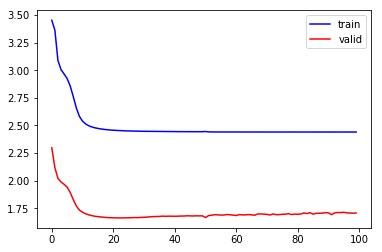

In [10]:
plt.plot(np.arange(len(model1.train_losses)), model1.train_losses, 'b', label = 'train')
plt.plot(np.arange(len(model1.valid_losses)), model1.valid_losses, 'r', label = 'valid')
plt.legend()
plt.show()